In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from datetime import datetime

from matplotlib import rc,rcParams

rc('text', usetex=False)
rc('axes', linewidth=2)
rc('font', weight='bold')

import json
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import statsmodels.api as sm

In [3]:
file = '../data/data_filtered.pkl'
with open(file, 'rb') as handle:
    data_dict = pickle.load(handle)

In [4]:
data_dict.keys()

dict_keys(['AXISBANK', 'BAJFINANCE', 'BAJAJHLDNG', 'CHOLAFIN', 'HDFCBANK', 'ICICIBANK', 'KOTAKBANK', 'SBIN'])

In [5]:
stocks_under_cosideration = ['BAJAJHLDNG', 'CHOLAFIN']

In [6]:
data_filtered = {}
for stocks in stocks_under_cosideration:
    data_filtered[stocks] = data_dict[stocks]

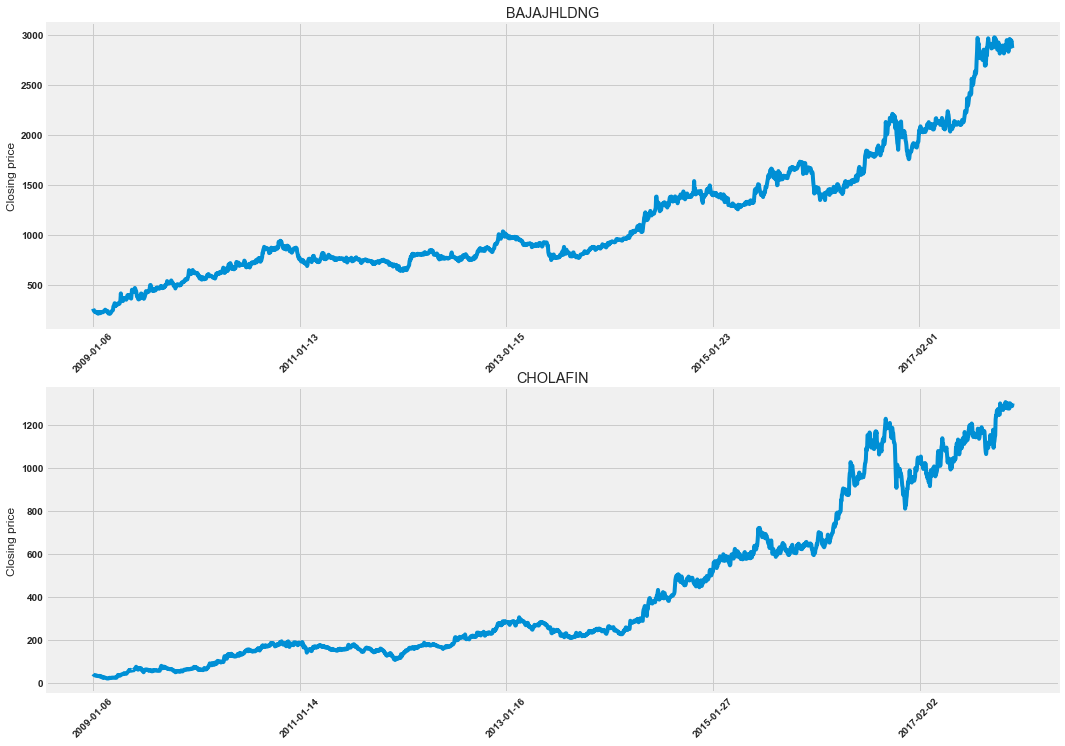

In [7]:
period_start = '2009-01-06'
period_end = '2017-12-31'
final_data = {}
plt.figure(figsize=(15, 10))
#plt.subplots_adjust(top=14, bottom=13) 
for i, company in enumerate(data_filtered.keys(), 1):
    plt.subplot(2,1, i)
    plt.tight_layout()
    data_filtered[company]['nse_closing_price'].loc[period_start:period_end].plot()
    final_data[company] = data_filtered[company].loc[period_start:period_end]
    plt.ylabel('Closing price')
    plt.xlabel(None)
    plt.xticks(rotation = '45')
    plt.title(f"{company}")
plt.show()

## ARIMA (AutoRegressive Integrated Moving Average) MODEL 

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are - 

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The parameters of the ARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average

![alt text](../images/arima.png)

We are using p = 5, d = 1, q = 0

### BAJAJHLDING

In [8]:
bajaj = final_data['BAJAJHLDNG']
train_ratio = 0.9
bajaj_train, bajaj_test = bajaj[0:int(len(bajaj)*train_ratio)], bajaj[int(len(bajaj)*train_ratio):]

In [9]:
bajaj.head()

,company_name,nse_opening_price,nse_high_price,nse_low_price,nse_closing_price,nse_returns,nse_traded_qty,nse_no_of_trans,daily_return
co_stkdate,,,,,,,,,
2009-01-06,BAJAJ HOLDINGS & INVST. LTD.,261.10,266.00,257.05,263.75,1.01,27113.0,1283.0,0.010343
2009-01-07,BAJAJ HOLDINGS & INVST. LTD.,261.30,271.80,240.00,248.85,0.94,46566.0,2093.0,-0.056493
2009-01-09,BAJAJ HOLDINGS & INVST. LTD.,248.85,248.85,230.50,241.30,0.97,30610.0,1508.0,-0.030340
2009-01-12,BAJAJ HOLDINGS & INVST. LTD.,239.00,244.00,230.00,235.20,0.97,11150.0,844.0,-0.025280
2009-01-13,BAJAJ HOLDINGS & INVST. LTD.,235.95,247.00,231.50,234.70,1.00,24334.0,2039.0,-0.002126


In [21]:
bajaj_test.head()

,company_name,nse_opening_price,nse_high_price,nse_low_price,nse_closing_price,nse_returns,nse_traded_qty,nse_no_of_trans,daily_return
co_stkdate,,,,,,,,,
2017-02-07,BAJAJ HOLDINGS & INVST. LTD.,2099.70,2099.7,2023.05,2033.10,0.97,20040.0,3119.0,-0.025710
2017-02-08,BAJAJ HOLDINGS & INVST. LTD.,2045.80,2090.0,2037.00,2049.55,1.01,31196.0,2776.0,0.008091
2017-02-09,BAJAJ HOLDINGS & INVST. LTD.,2053.00,2079.0,2040.10,2058.55,1.00,8964.0,1506.0,0.004391
2017-02-10,BAJAJ HOLDINGS & INVST. LTD.,2062.70,2069.3,2030.00,2040.35,0.99,6713.0,859.0,-0.008841
2017-02-13,BAJAJ HOLDINGS & INVST. LTD.,2058.95,2073.3,2018.00,2031.65,1.00,6050.0,915.0,-0.004264


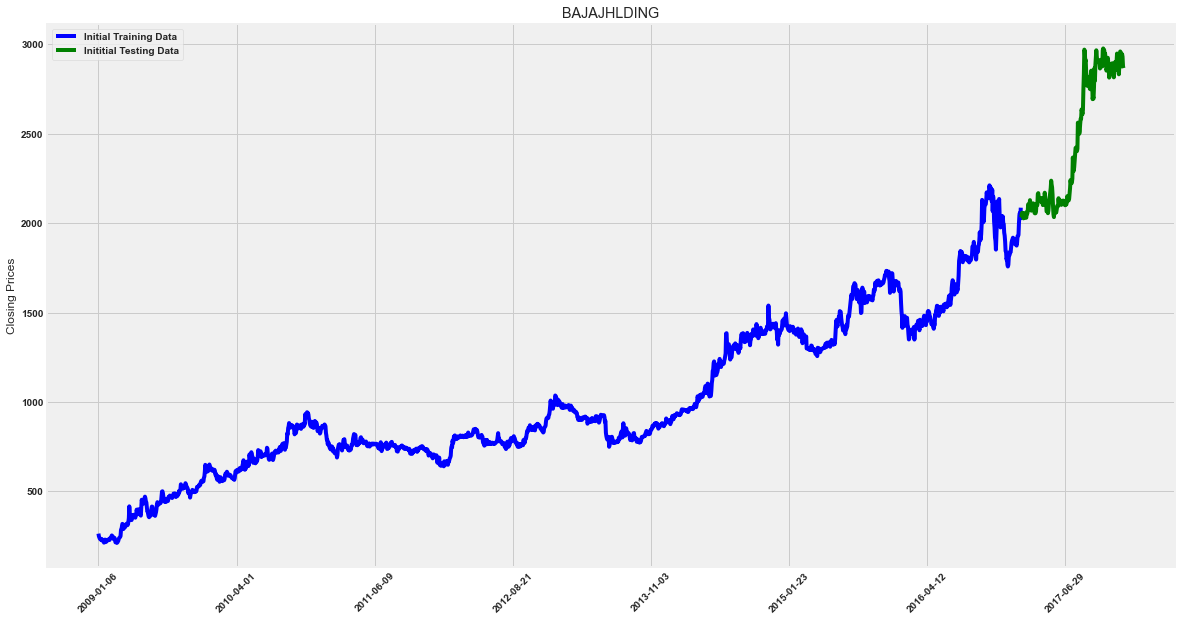

In [22]:
plt.figure(figsize=(18,10))
plt.title('BAJAJHLDING')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(bajaj_train['nse_closing_price'], 'blue', label='Initial Training Data')
plt.plot(bajaj_test['nse_closing_price'], 'green', label='Inititial Testing Data')
plt.xticks(np.arange(0,len(bajaj), 300), rotation = 45)
plt.xlabel(None)
plt.legend()
plt.show()

In [11]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [26]:
train_ar = bajaj_train['nse_closing_price'].values
test_ar = bajaj_test['nse_closing_price'].values

history = [x for x in train_ar]
print(type(history))
bajaj_predictions = list()

for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    bajaj_predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, bajaj_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 1236.905
Symmetric mean absolute percentage error: 73.461


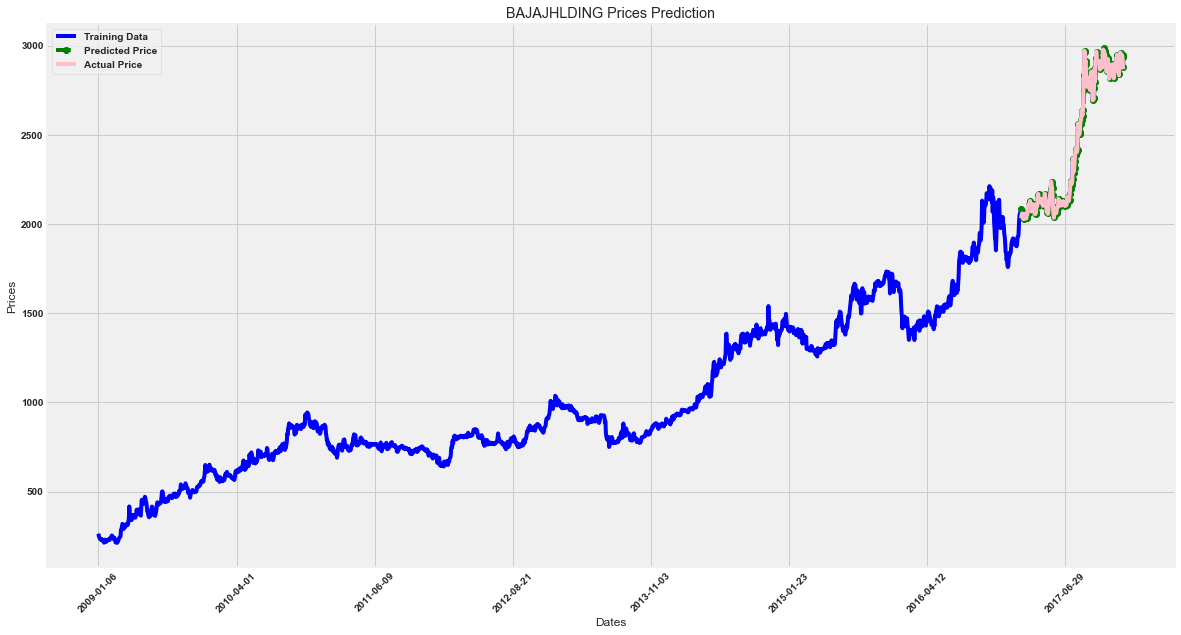

In [32]:
plt.figure(figsize=(18,10))
plt.plot(bajaj['nse_closing_price'], 'green', color='blue', label='Training Data')
plt.plot(bajaj_test.index, bajaj_predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(bajaj_test.index, bajaj_test['nse_closing_price'], color='pink', label='Actual Price')
plt.title('BAJAJHLDING Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,len(bajaj), 300), rotation = 45)
plt.legend()

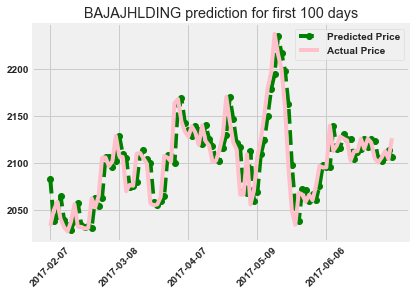

In [28]:
plt.title('BAJAJHLDING prediction for first 100 days')
plt.plot(bajaj_test.index[:100], bajaj_predictions[:100], color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(bajaj_test.index[:100], bajaj_test['nse_closing_price'].iloc[:100], color='pink', label='Actual Price')
plt.xticks(np.arange(0,len(bajaj_test.iloc[:100]), 20), rotation = 45)
plt.legend()
plt.show()

### CHOLAFIN

In [15]:
chola = final_data['CHOLAFIN']
train_ratio = 0.9
chola_train, chola_test = chola[0:int(len(chola)*train_ratio)], chola[int(len(chola)*train_ratio):]

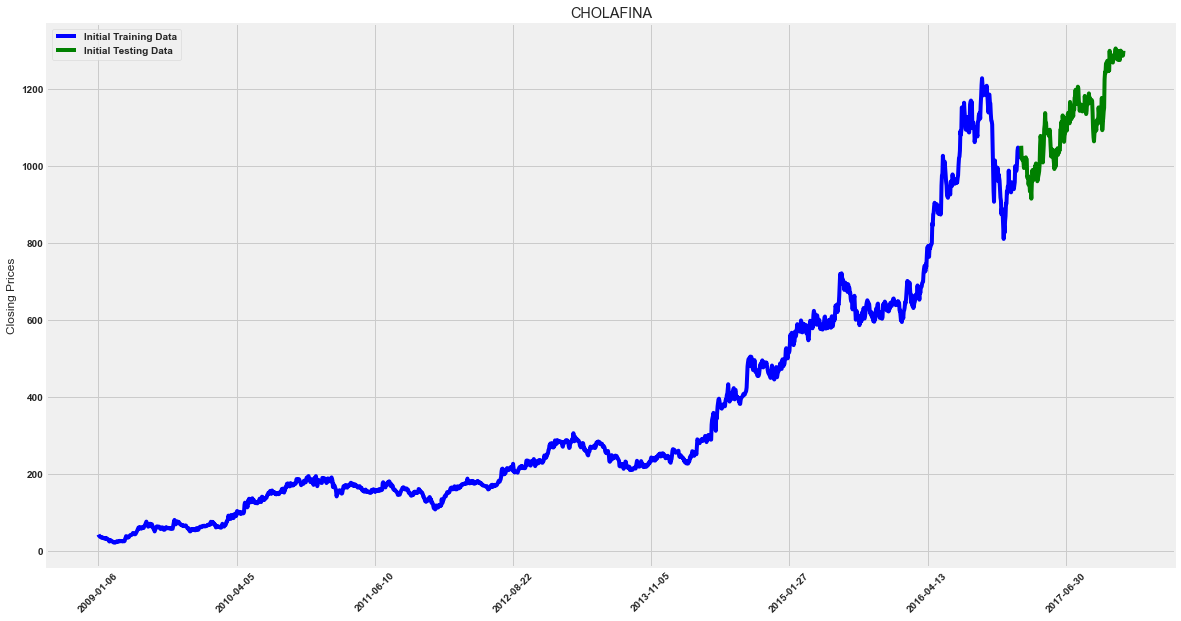

In [23]:
plt.figure(figsize=(18,10))
plt.title('CHOLAFINA')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(chola_train['nse_closing_price'], 'blue', label='Initial Training Data')
plt.plot(chola_test['nse_closing_price'], 'green', label='Initial Testing Data')
plt.xticks(np.arange(0,len(bajaj), 300), rotation = 45)
plt.xlabel(None)
plt.legend()
plt.show()

In [17]:
chola_train.fillna(method='ffill', inplace = True)

In [29]:
train_ar = chola_train['nse_closing_price'].values
test_ar = chola_test['nse_closing_price'].values

history = [x for x in train_ar]
print(type(history))
chola_predictions = list()

for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    chola_predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, chola_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)


<class 'list'>
Testing Mean Squared Error: 377.405
Symmetric mean absolute percentage error: 10.066


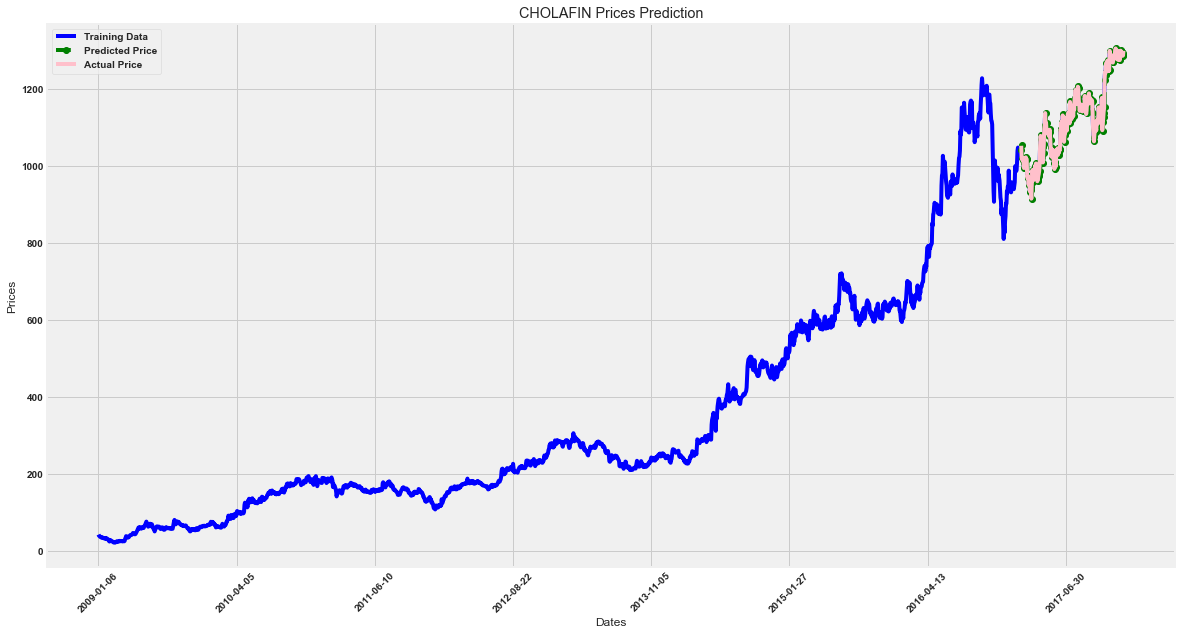

In [30]:
plt.figure(figsize=(18,10))
plt.plot(chola['nse_closing_price'], 'green', color='blue', label='Training Data')
plt.plot(chola_test.index, chola_predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(chola_test.index, chola_test['nse_closing_price'], color='pink', label='Actual Price')
plt.title('CHOLAFIN Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,len(chola), 300), rotation = 45)
plt.legend()

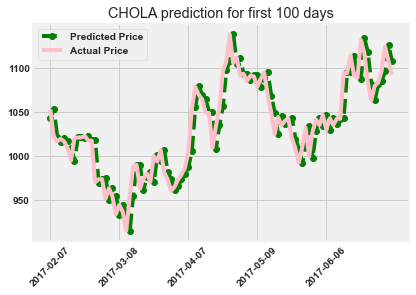

In [31]:
plt.title('CHOLA prediction for first 100 days')
plt.plot(chola_test.index[:100], chola_predictions[:100], color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(chola_test.index[:100], chola_test['nse_closing_price'].iloc[:100], color='pink', label='Actual Price')
plt.xticks(np.arange(0,len(chola_test.iloc[:100]), 20), rotation = 45)
plt.legend()
plt.show()

## SARIMA

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

### Trend Elements

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

### Seasonal Elements

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.



### BAJAJHLDING

In [31]:
trend_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

train_ar = bajaj_train['nse_closing_price'].values
test_ar = bajaj_test['nse_closing_price'].values

history = [x for x in train_ar]
print(type(history))
model = sm.tsa.statespace.SARIMAX(history, order=trend_order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=0)
predictions = model_fit.forecast(steps = len(test_ar))
#obs = test_ar[t]
#history.append(obs)
#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 143900.475
Symmetric mean absolute percentage error: 11.067


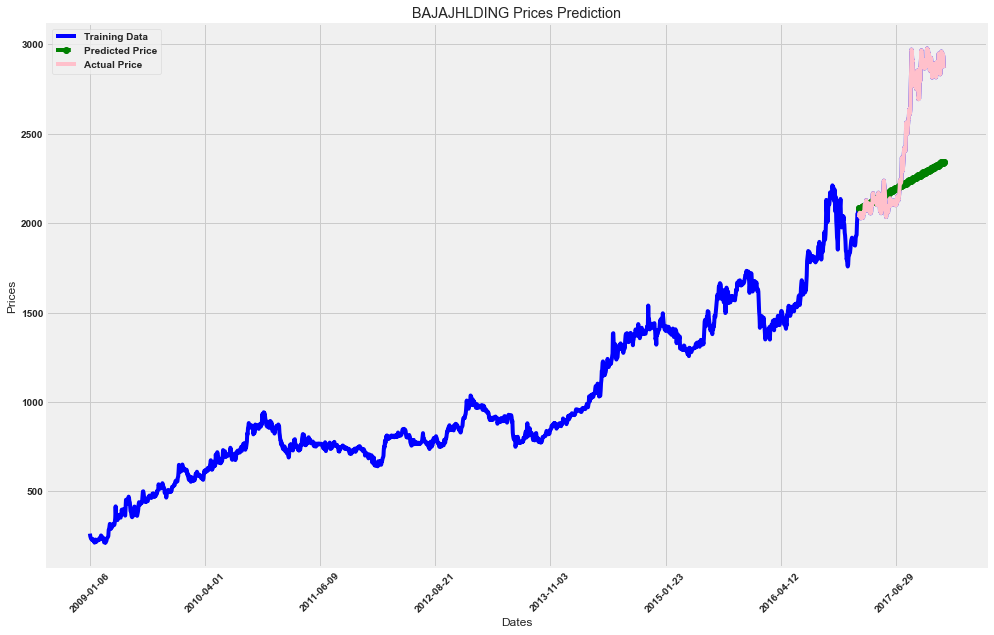

In [32]:
plt.figure(figsize=(15,10))
plt.plot(bajaj['nse_closing_price'], 'green', color='blue', label='Training Data')
plt.plot(bajaj_test.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(bajaj_test.index, bajaj_test['nse_closing_price'], color='pink', label='Actual Price')
plt.title('BAJAJHLDING Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,len(bajaj), 300), rotation = 45)
plt.legend()

### Rolling SARIMA forecast model will take too much compute time